# **Projecting Player Value Using FIFA Data**

### Study Objectives 

- Use physical/stats attributes to predict player value and determine which players are overvalued/undervalued.

## Data Collection

First, we collect data via web-scraping using Beautiful Soup.

```python
#import required packages
from bs4 import BeautifulSoup
import requests
import pandas as pd

#initialize variables of interest
player_id = []
name = []
origin_country = []
club = []
primary_position = []
age = []
height = []
weight = []
primary_foot = []
attacking = []
skill = []
movement = []
power = []
mentality = []
defending = []
value = []

#initialize link
base = "https://sofifa.com/players?r=210064&set=true&showCol%5B%5D=pishowCol%5B%5D=ae&showCol%5B%5D=hi&showCol%5B%5D=wi&showCol%5B%5D=pf&showCol%5B%5D=vl&showCol%5B%5D=ta&showCol%5B%5D=ts&showCol%5B%5D=to&showCol%5B%5D=tp&showCol%5B%5D=te&showCol%5B%5D=td&offset="
offset = 0
link = base + str(offset)

#loop through pages extracting information of interest
for page in range(200):

    html_raw = requests.get(link)
    soup = BeautifulSoup(html_raw.content, "html.parser")

    rows = soup.find_all('tr')

    for i in range(1,len(rows)):

        # get 
        player_id.append(rows[i].find(class_ = "col col-pi").text) #id
        
        name.append(rows[i].find_all(class_ = "ellipsis")[0].text) #name 
        
        origin_country.append(rows[i].find('img', class_ = "flag").get("title")) #origin country
        
        club.append(rows[i].find_all(class_ = "ellipsis")[1].text.strip().split("\n", 1)[0]) #club
        
        primary_position.append(rows[i].find_all(class_ = "pos")[0].text) #primary position
        
        age.append(rows[i].find(class_ = "col col-ae").text) #age
        
        weight.append(rows[i].find(class_ = "col col-wi").text) #weight
        
        primary_foot.append(rows[i].find(class_ = "col col-pf").text) #primary foot
        
        attacking.append(rows[i].find(class_ = "col col-ta").text) #attack
        
        skill.append(rows[i].find(class_ = "col col-ts").text) #skill
        
        movement.append(rows[i].find(class_ = "col col-to").text) #movement
        
        power.append(rows[i].find(class_ = "col col-tp").text) #power
        
        mentality.append(rows[i].find(class_ = "col col-te").text) # mentality
        
        defending.append(rows[i].find(class_ = "col col-td").text) # defending 
        
        value.append(rows[i].find(class_ = "col col-vl").text.split("€", 1)[1]) #value

    #get next link
    offset += 60
    link = base + str(offset)

#creat a data frame with the new
df = pd.DataFrame({
    "player_id": player_id,
    "name": name,
    "origin_country": origin_country,
    "club": club,
    "primary_position": primary_position,
    "age": age,
    "height": height,
    "weight": weight,
    "primary_foot": primary_foot,
    "attacking": attacking,
    "skill": skill,
    "movement": movement,
    "power": power,
    "mentality": mentality,
    "defending": defending,
    "value": value
})

print(df)

#save the file out so we do not have to run this chunk
df.to_csv("fifa_players.csv", index=False)
```

## Data Cleaning

Next, we move on to cleaning the data.

In [146]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats 
import missingno as msno
import warnings

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [147]:
# read in data and print head
df21 = pd.read_csv('fifa_players.csv')
print(f"The data has dimensions {df21.shape[0]} x {df21.shape[1]}.")
df21.head()

The data has dimensions 12000 x 16.


,player_id,name,origin_country,club,primary_position,age,height,weight,primary_foot,attacking,skill,movement,power,mentality,defending,value
0,158023,L. Messi,Argentina,Paris Saint-Germain,RW,33,170cm,72kg,Left,429,470,451,389,347,91,103.5M
1,188545,R. Lewandowski,Poland,FC Bayern München,ST,31,185cm,81kg,Right,430,407,408,423,396,96,124.5M
2,20801,Cristiano Ronaldo,Portugal,Juventus,ST,35,187cm,83kg,Right,437,414,431,444,353,84,63M
3,200389,J. Oblak,Slovenia,Atlético de Madrid,GK,27,188cm,87kg,Right,95,109,307,268,140,57,120M
4,192985,K. De Bruyne,Belgium,Manchester City,CM,29,181cm,70kg,Right,407,441,402,408,407,186,127.5M


Here, we perform basic data cleaning like dealing with units and making more readable column names.

---



In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
# hiding warnings
warnings.filterwarnings('ignore')

# changing value units
for index, value in enumerate(df21['value']):
  if value[-1] == 'M':
    df21['value'][index] = float(value[:-1]) * 1000000
  elif value[-1] == 'K':
    df21['value'][index] = float(value[:-1]) * 1000
  else:
    df21['value'][index] = float(value)
df21['value'] = df21['value'].astype(float)

# changing height units
for index, value in enumerate(df21['height']):
  df21['height'][index] = float(value[:-2])
df21['height'] = df21['height'].astype(float)

# changing weight units
for index, value in enumerate(df21['weight']):
  df21['weight'][index] = float(value[:-2])
df21['weight'] = df21['weight'].astype(float)


df21.columns = ['Player ID', 'Name', 'Origin Country', 'Club', 'Primary Position', 'Age', 'Height (cm)',
       'Weight (kg)', 'Primary Foot', 'Attacking', 'Skill', 'Movement', 'Power',
       'Mentality', 'Defending', 'Value (Eur)']

df21.head(5)

,Player ID,Name,Origin Country,Club,Primary Position,Age,Height (cm),Weight (kg),Primary Foot,Attacking,Skill,Movement,Power,Mentality,Defending,Value (Eur)
0,158023,L. Messi,Argentina,Paris Saint-Germain,RW,33,170.0,72.0,Left,429,470,451,389,347,91,103500000.0
1,188545,R. Lewandowski,Poland,FC Bayern München,ST,31,185.0,81.0,Right,430,407,408,423,396,96,124500000.0
2,20801,Cristiano Ronaldo,Portugal,Juventus,ST,35,187.0,83.0,Right,437,414,431,444,353,84,63000000.0
3,200389,J. Oblak,Slovenia,Atlético de Madrid,GK,27,188.0,87.0,Right,95,109,307,268,140,57,120000000.0
4,192985,K. De Bruyne,Belgium,Manchester City,CM,29,181.0,70.0,Right,407,441,402,408,407,186,127500000.0


Next, we perform some standard data processing like checking for NAs, dropping duplicates, dummifying categorical predictors, and removing observations we don't care about.\
In this case, we believe removing goal keepers is justified as they consistently have different stats than field players.

---



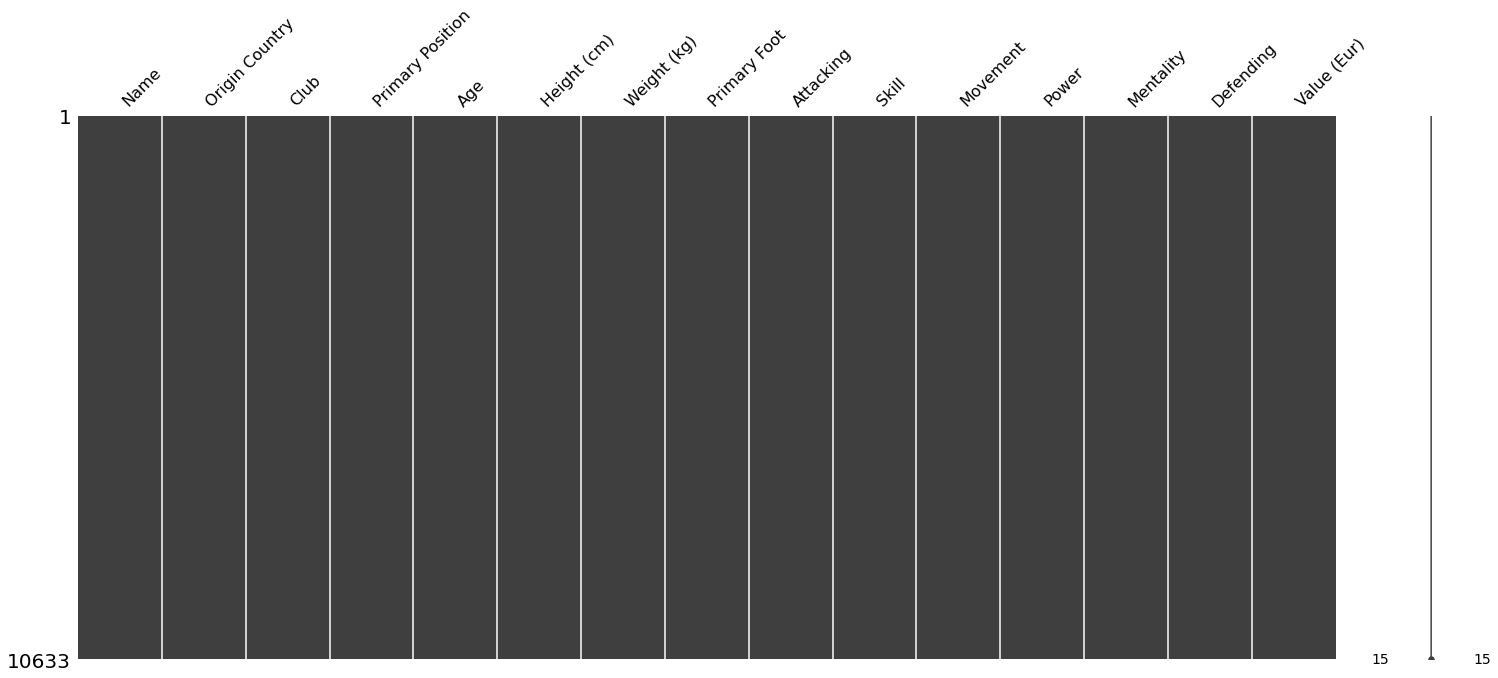

In [150]:
# copy df
df21_sub = df21.copy()

# drop duplicates
df21_sub = df21_sub.drop_duplicates('Player ID')

# drop goalkeepers
df21_sub = df21_sub[df21_sub['Primary Position'] != 'GK']

# drop players who make no money
df21_sub = df21_sub[df21_sub['Value (Eur)'] != 0]


# subset df based on needed columns
columns_needed = ['Name', 'Origin Country', 'Club', 'Primary Position', 'Age', 'Height (cm)','Weight (kg)', 'Primary Foot', 'Attacking', 'Skill', 'Movement', 'Power', 'Mentality', 'Defending', 'Value (Eur)']
df21_sub = df21_sub.loc[:, columns_needed]

# change primary foot to numerical (1 = Right, 2 = Left)
df21_sub['Primary Foot'] = df21_sub['Primary Foot'].apply(lambda x: 1 if x=='Right' else 0)

#finally plot missing data to examine missingingness
msno.matrix(df21_sub)
plt.show()

As we can see, there is no missing data!

## Exploratory Analysis

 Let's examine the distribution of a few of our predictors and the summary statistics for the entire dataset.

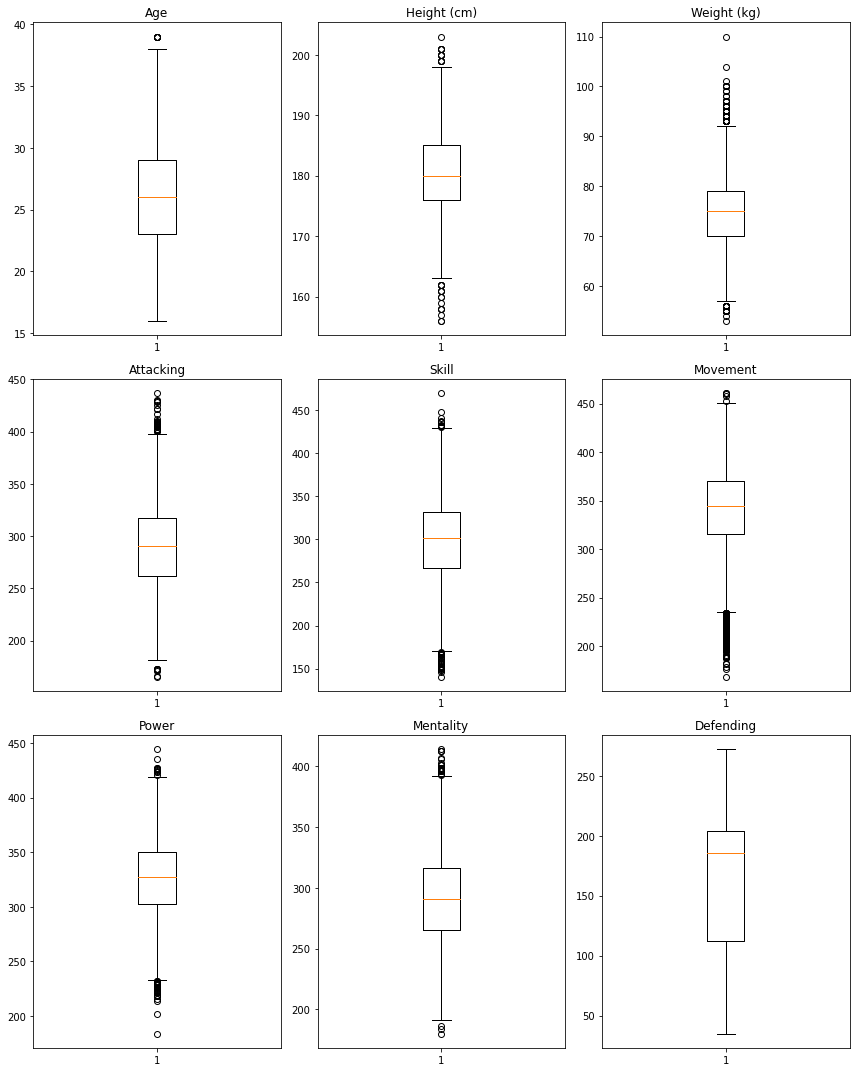

In [151]:
fig,ax = plt.subplots(3,3)
ax = ax.flatten()
fig.set_figheight(15)
fig.set_figwidth(12)

quant_vars = ['Age', 'Height (cm)','Weight (kg)', 'Attacking', 'Skill', 'Movement', 'Power', 'Mentality', 'Defending']

for index in range(len(quant_vars)):
    ax[index].boxplot(df21_sub[quant_vars[index]])
    ax[index].set_title(f"{quant_vars[index]}")
    plt.tight_layout()


In [152]:
# descriptive statistics
df21_sub.describe()

,Age,Height (cm),Weight (kg),Primary Foot,Attacking,Skill,Movement,Power,Mentality,Defending,Value (Eur)
count,10633.000000,10633.000000,10633.000000,10633.000000,10633.000000,10633.000000,10633.000000,10633.000000,10633.000000,10633.000000,1.063300e+04
mean,26.002069,180.588921,74.872002,0.734412,289.212828,298.665193,340.035456,325.955046,291.269538,162.807016,4.387358e+06
std,4.164054,6.565639,6.733149,0.441667,40.785279,48.641150,43.385425,33.348509,35.890781,53.953391,9.356503e+06
min,16.000000,156.000000,53.000000,0.000000,165.000000,140.000000,168.000000,184.000000,180.000000,35.000000,1.000000e+05
25%,23.000000,176.000000,70.000000,0.000000,262.000000,267.000000,316.000000,303.000000,265.000000,112.000000,1.100000e+06
50%,26.000000,180.000000,75.000000,1.000000,291.000000,302.000000,345.000000,327.000000,291.000000,186.000000,1.700000e+06
75%,29.000000,185.000000,79.000000,1.000000,317.000000,332.000000,370.000000,350.000000,316.000000,204.000000,3.300000e+06
max,39.000000,203.000000,110.000000,1.000000,437.000000,470.000000,461.000000,444.000000,414.000000,272.000000,1.855000e+08


One thing we noticed is that the response variable, Value (Eur), has several outliers.\
Therefore, we performed a transformation of log base 10 on Value (Eur) in order to get a more normal distribution.

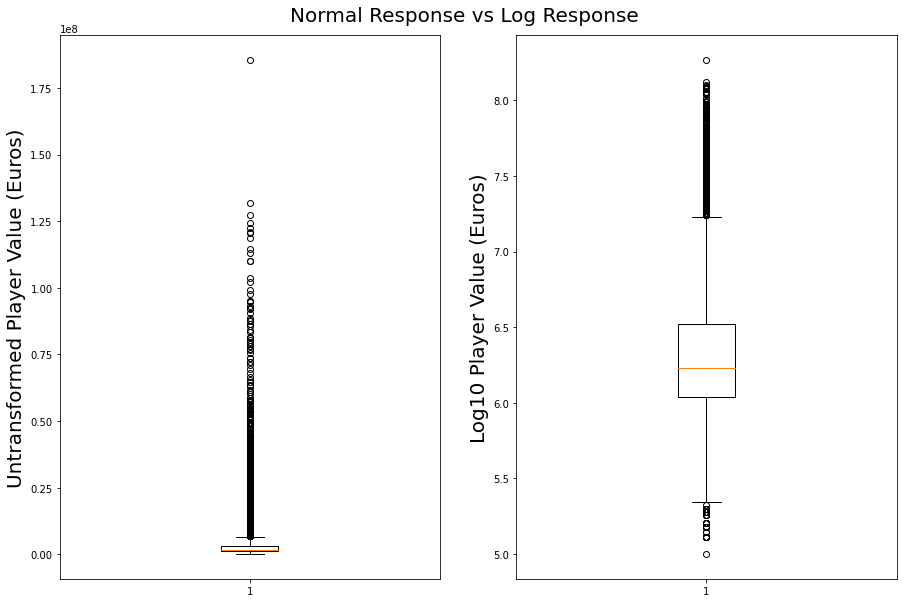

In [153]:
# plotting response
fig,ax = plt.subplots(1,2)
ax = ax.flatten()
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0].boxplot(df21_sub['Value (Eur)'])
ax[0].set_xlabel('', fontsize = 20)
ax[0].set_ylabel('Untransformed Player Value (Euros)', fontsize = 20)
ax[1].boxplot(np.log10(df21_sub['Value (Eur)'].astype(int)))
ax[1].set_xlabel('', fontsize = 20)
ax[1].set_ylabel('Log10 Player Value (Euros)', fontsize = 20)

plt.suptitle('Normal Response vs Log Response', fontsize = 20, y = 0.92)
plt.show()

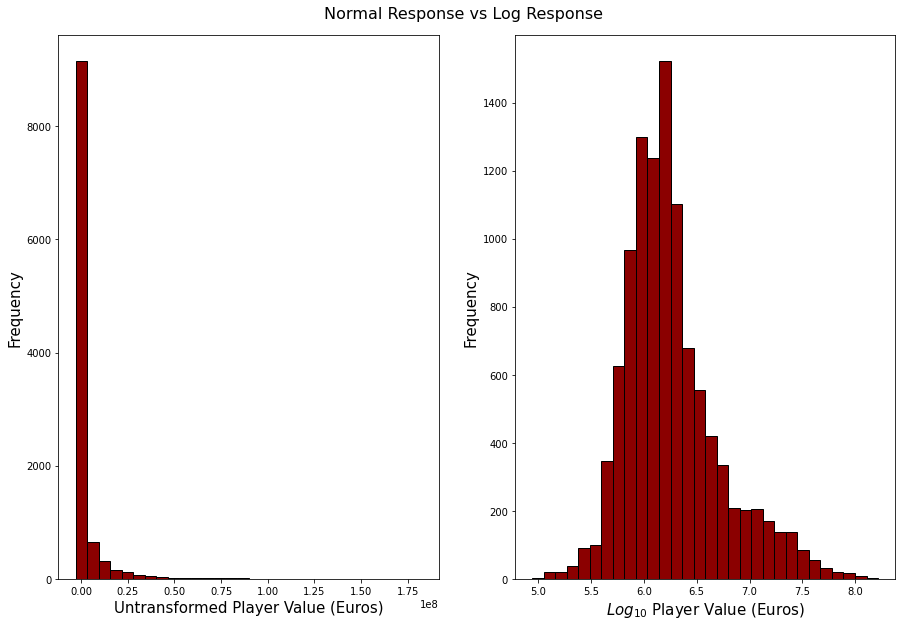

In [154]:
# plotting response
fig,ax = plt.subplots(1,2)
ax = ax.flatten()
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0].hist(df21_sub['Value (Eur)'], bins=30, align='left', color='darkred', edgecolor='black',linewidth=1)
ax[0].set_ylabel('Frequency', fontsize = 15)
ax[0].set_xlabel('Untransformed Player Value (Euros)', fontsize = 15)
ax[1].hist(np.log10(df21_sub['Value (Eur)'].astype(int)), bins=30, align='left', color='darkred', edgecolor='black',linewidth=1)
ax[1].set_xlabel('$Log_{10}$ Player Value (Euros)', fontsize = 15)
ax[1].set_ylabel('Frequency', fontsize = 15)

plt.suptitle('Normal Response vs Log Response', fontsize = 16, y = 0.92)
plt.show()

Next, we examine correlation for the data set to asses colinearity between predictors.

In [155]:
# correlation matrix
df21_sub.corr()

,Age,Height (cm),Weight (kg),Primary Foot,Attacking,Skill,Movement,Power,Mentality,Defending,Value (Eur)
Age,1.000000,0.040461,0.165683,0.026841,0.171912,0.105962,-0.214063,0.230413,0.271223,0.084793,-0.069050
Height (cm),0.040461,1.000000,0.757631,0.047975,-0.189556,-0.387830,-0.646093,0.081981,-0.116123,0.173253,0.008801
Weight (kg),0.165683,0.757631,1.000000,0.059889,-0.126454,-0.327098,-0.579725,0.179755,-0.059413,0.131302,0.013430
Primary Foot,0.026841,0.047975,0.059889,1.000000,-0.009101,-0.100541,-0.052280,0.055876,-0.005476,-0.055637,-0.003140
Attacking,0.171912,-0.189556,-0.126454,-0.009101,1.000000,0.789329,0.458915,0.633813,0.633779,-0.373493,0.397164
Skill,0.105962,-0.387830,-0.327098,-0.100541,0.789329,1.000000,0.542479,0.475304,0.685350,-0.156149,0.369279
Movement,-0.214063,-0.646093,-0.579725,-0.052280,0.458915,0.542479,1.000000,0.206388,0.242451,-0.299068,0.273518
Power,0.230413,0.081981,0.179755,0.055876,0.633813,0.475304,0.206388,1.000000,0.602275,-0.078696,0.316804
Mentality,0.271223,-0.116123,-0.059413,-0.005476,0.633779,0.685350,0.242451,0.602275,1.000000,0.268908,0.393369
Defending,0.084793,0.173253,0.131302,-0.055637,-0.373493,-0.156149,-0.299068,-0.078696,0.268908,1.000000,0.085254


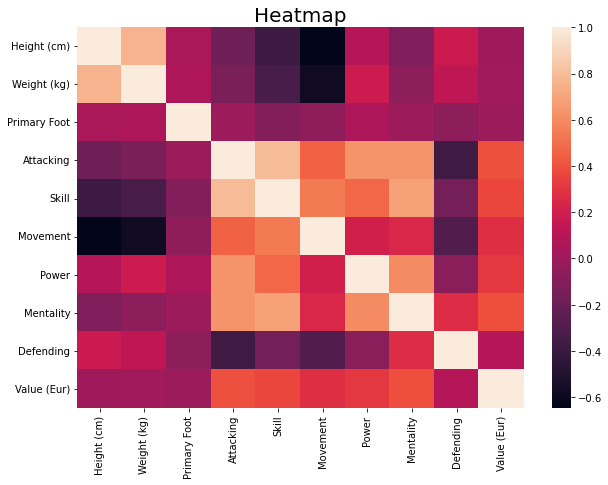

In [156]:
# plotting correlation
plt.figure(figsize=(10, 7))
correlation_vars = df21_sub.columns[5:]
sns.heatmap(df21_sub.loc[:,correlation_vars].corr()).set_title('Heatmap', fontsize = 20)
plt.show()

In [157]:
# list of top 15 absolute value of correlation values, ignores first row because irrelevant
pd.DataFrame(df21_sub.loc[:, correlation_vars].corr().unstack().abs().sort_values(ascending = False).drop_duplicates()[1:15], columns = ['Correlation'])

Correlation
Skill       Attacking       0.789329
Height (cm) Weight (kg)     0.757631
Mentality   Skill           0.685350
Height (cm) Movement        0.646093
Attacking   Power           0.633813
            Mentality       0.633779
Power       Mentality       0.602275
Movement    Weight (kg)     0.579725
Skill       Movement        0.542479
            Power           0.475304
Attacking   Movement        0.458915
            Value (Eur)     0.397164
Mentality   Value (Eur)     0.393369
Skill       Height (cm)     0.387830

To hone in on the correlation of our predictors and response, we create scatter plots to analyze the relationship between them. This gives us a good idea on what predictors we should expect to play significiant roles in predicting the response variable.

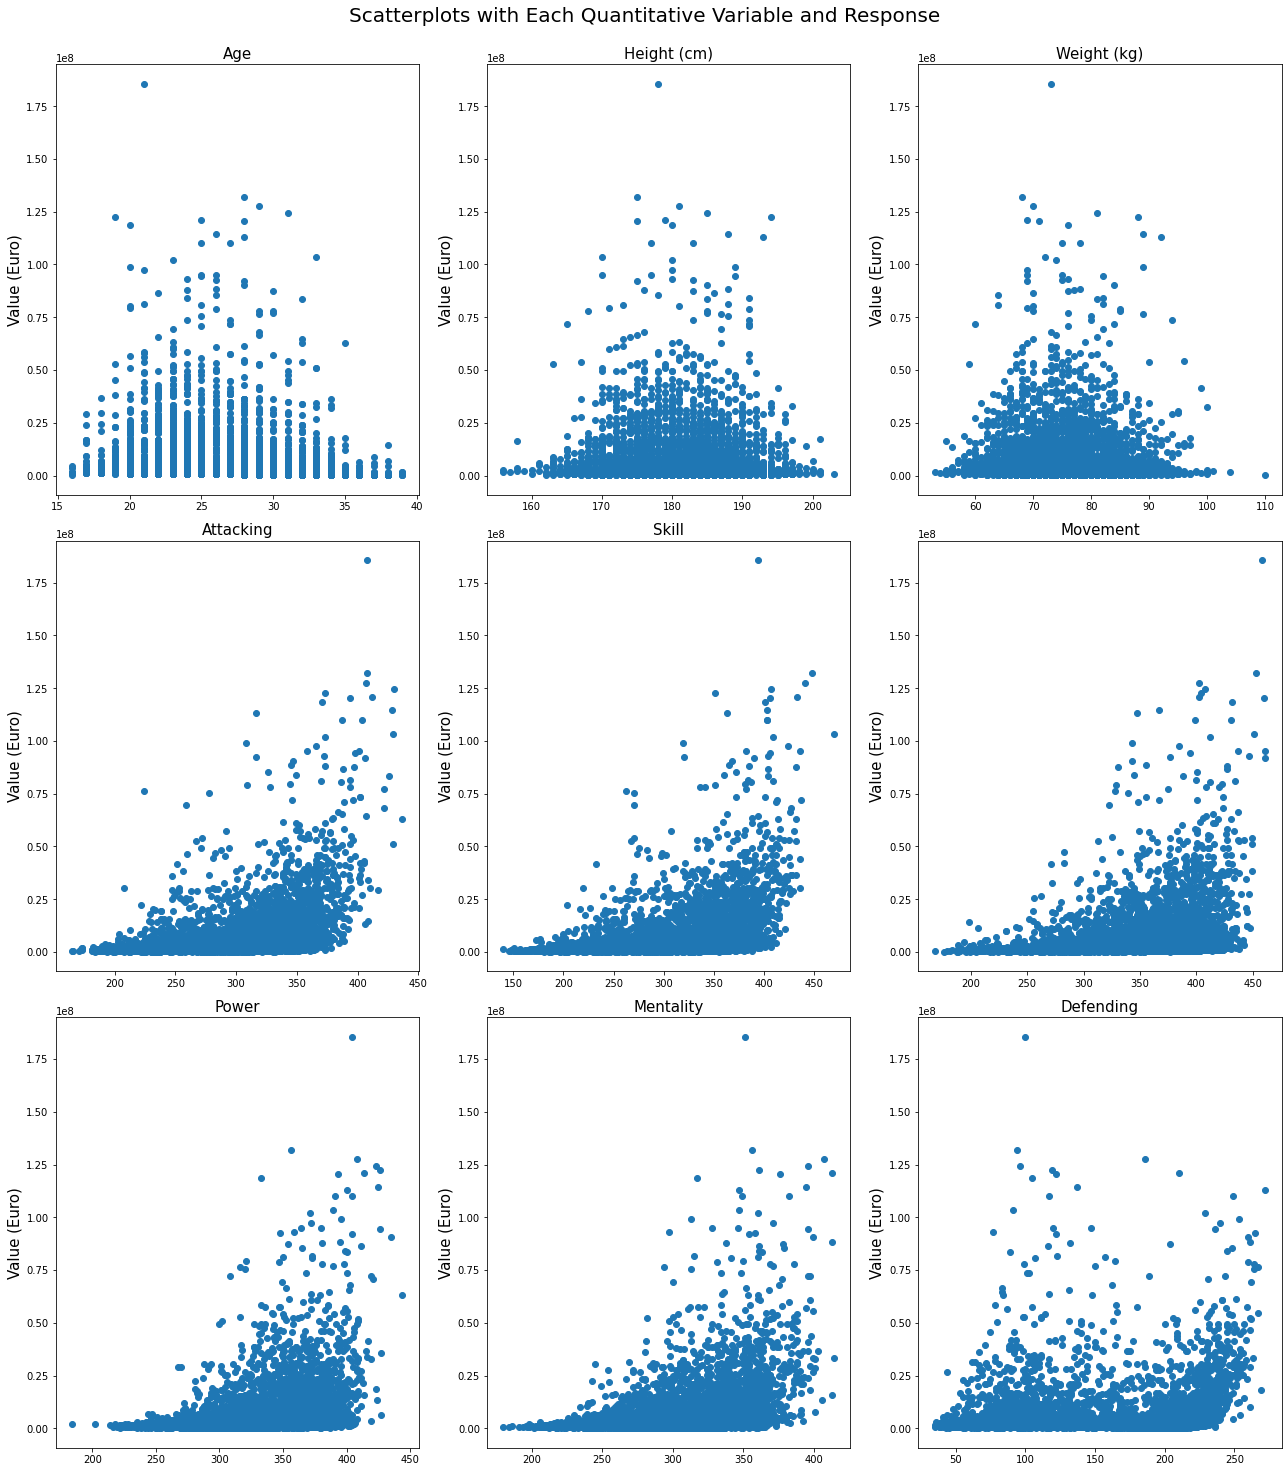

In [158]:
# plotting
fig,ax = plt.subplots(3,3)
ax = ax.flatten()
fig.set_figheight(20)
fig.set_figwidth(18)

for index in range(len(quant_vars)):
    ax[index].scatter(df21_sub[quant_vars[index]], df21_sub['Value (Eur)'])
    ax[index].set_title(f"{quant_vars[index]}", fontsize = 15)
    ax[index].set_ylabel('Value (Euro)', fontsize = 15)
    plt.tight_layout()
plt.suptitle('Scatterplots with Each Quantitative Variable and Response', y=1.02, fontsize = 20)
plt.show()

In [159]:
# split data into x and y, using regression vars
regression_vars = ['Age', 'Height (cm)', 'Weight (kg)', 'Primary Foot','Attacking','Skill', 'Movement', 'Power', 'Mentality', 'Defending']
y = df21_sub[['Value (Eur)']].values
X = df21_sub.loc[:,regression_vars]

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 50)

# log the response
y_train = np.log10(y_train)
y_test = np.log10(y_test)

In [160]:
# initialize dictionary to store results
best_mse_dict = {}
best_mse_dict['Train'] = {}
best_mse_dict['Val'] = {}

In [161]:
# define print results function
def print_and_update(model, best_CV_score, best_train_score, y_train, y_train_preds):
    print(f'Results of the {model} model:')
    print('--------------------------------')
    print(f"Train $r^2$: {round(r2_score(y_train, y_train_preds),4)}")
    print(f"Train MSE: {round(best_train_score,4)}") 
    print(f"Validation MSE: {round(best_CV_score,4)}")  
    best_mse_dict['Train'][model] = round(best_train_score,4)
    best_mse_dict['Val'][model] = round(best_CV_score,4)


## Preliminary Model

Finally, we fit a preliminary multi-regression model to determine the relationship between these players' physical attributes and value. We print the results below.

In [162]:
# instantiate object
linreg = LinearRegression()

# fit linear regression on training data
linreg.fit(X_train, y_train)

# get training predictions, training score
y_preds_train = linreg.predict(X_train)
train_score_linreg = mean_squared_error(y_train, y_preds_train)

#get cross validated scores
cv_scores = cross_val_score(linreg, X_train, y_train, cv = 10, scoring = ('neg_mean_squared_error'))
cv_score_linreg = np.absolute(np.mean(cv_scores))

print_and_update('Preliminary', cv_score_linreg, train_score_linreg, y_train, y_preds_train)

Results of the Preliminary model:
--------------------------------
Train $r^2$: 0.5673
Train MSE: 0.0883
Validation MSE: 0.0885


The preliminary model gives us a validation MSE of 0.0885. We hope to improve on this moving forward. Below is also an example scatter plot of one feature variable and the response.

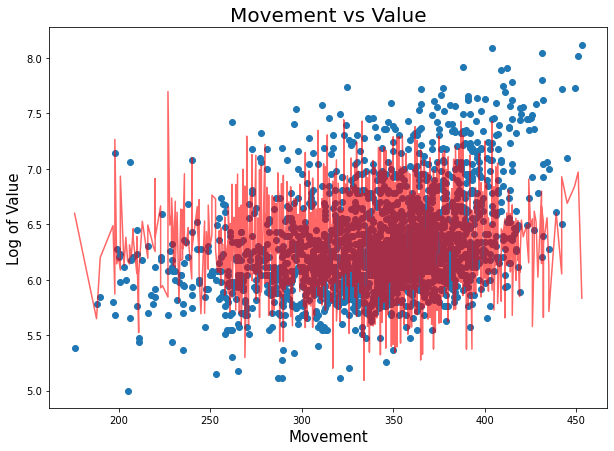

In [163]:
# Convert x test to numpy array to sort
X_te = X_test['Movement']
X_te = X_te.to_numpy()

#Sort x and y test data
idx = np.argsort(X_te)
X_te = X_te[idx]
y_te = y_test[idx]
y_preds= y_preds_train[idx]

#Plotting the preliminary model on a 2D graph using just movement and value
plt.figure(figsize=(10, 7))
plt.scatter(X_te,y_te)
plt.plot(X_te,y_preds, color = 'red', alpha = 0.6)
plt.xlabel('Movement', fontsize = 15)
plt.ylabel('Log of Value', fontsize = 15)
plt.title('Movement vs Value', fontsize = 20)
plt.show()

## Advanced Modeling and Model Selection

Now, we will move on to more substantial methods for finding the best predictive model.

### k-Nearest Neighbors

In [164]:
# initialize k list
k_list = [1,2,3,5,7,10,50,100]

# normalize feature variables
X_train_normalized = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_test_normalized = (X_test-X_test.min())/(X_test.max()-X_test.min())

train_scores = []
cv_means_knn = []
cv_stds_knn = []

for k in k_list:
    # initialize and fit
    kNN = KNeighborsRegressor(n_neighbors = k)
    kNN.fit(X_train_normalized, y_train)

    #get train scores
    y_preds_train = kNN.predict(X_train_normalized)
    train_scores.append(mean_squared_error(y_train, y_preds_train))

    #get cross validated scores
    cv_scores = cross_val_score(kNN, X_train_normalized, y_train, cv = 10, scoring = ('neg_mean_squared_error'))
    cv_means_knn.append(np.absolute(np.mean(cv_scores)))
    cv_stds_knn.append(np.absolute(np.std(cv_scores)))

# getting best score and best k
best_score = min(cv_means_knn)
best_k = k_list[cv_means_knn.index(best_score)]

# calculating lower and upper bounds
up_bound_knn = np.array(cv_means_knn) + np.array(cv_stds_knn)
low_bound_knn = np.array(cv_means_knn) - np.array(cv_stds_knn)

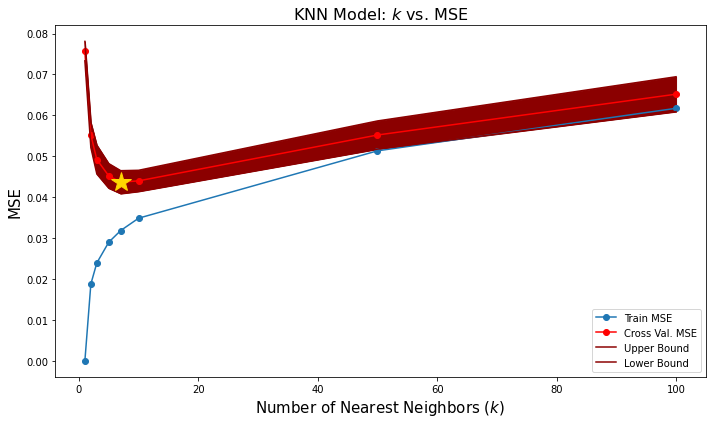

In [165]:
# plotting
plt.figure(figsize = (10,6))
plt.plot(k_list, train_scores, label = 'Train MSE', marker = 'o')
plt.plot(k_list, cv_means_knn, label = 'Cross Val. MSE', c='red', marker = 'o')
plt.plot(k_list, up_bound_knn, label = 'Upper Bound', color = 'darkred')
plt.plot(k_list, low_bound_knn, label = 'Lower Bound', color = 'darkred')
plt.plot(best_k, best_score, marker = '*', markersize = 20, color = 'gold')
plt.fill_between(k_list, up_bound_knn, low_bound_knn, color='darkred')
plt.xlabel('Number of Nearest Neighbors ($k$)', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('KNN Model: $k$ vs. MSE', fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()

As seen above, the $k$ value which performs the best on the validation set is 7. We will also employ bootstrapping and compare the results.

In [166]:
# Define number of bootstraps
boots = 50

#Create empty list for MSE of each bootstrap
best_k_boot = []

#narrow k list
k_list = [5,6,7,8]

for i in range(boots):
  #creating a copy of the df with the y variable so it can be samples together
  boot_df = X_train_normalized.copy()
  boot_df['y'] = y_train

  #Sampling from data
  boot_df = boot_df.sample(frac=1, replace=True)

  #Resplitting data
  boot_y = boot_df['y']
  boot_X = boot_df.drop(['y'], axis = 1)

  boot_val_mse = []
  for k in k_list:
    knn_boot = KNeighborsRegressor(n_neighbors = k)

    #get cross validated scores
    score = cross_val_score(knn_boot, boot_X, boot_y, cv = 10, scoring = ('neg_mean_squared_error'))
    boot_val_mse.append(np.mean(np.absolute(score)))

    min_mse = min(boot_val_mse)
    best_k_boot.append(k_list[boot_val_mse.index(min_mse)])

#Count which k is best
count = []
for i in k_list:
    count.append(best_k_boot.count(i))

In [167]:
most_often = dict(zip(k_list, count))
most_often

{5: 197, 6: 3, 7: 0, 8: 0}

As you can see, the $k = 5$ model was picked drastically more often than any other. Therefore, we'll move ahead with $k = 5$ when evaluating KNN. Below, we report the results.

In [168]:
# instantiate object
best_k = KNeighborsRegressor(n_neighbors = 5)

# fit KNN on training data
best_k.fit(X_train_normalized, y_train)

# get training predictions, training score
y_preds_train = best_k.predict(X_train_normalized)
train_score_KNN = mean_squared_error(y_train, y_preds_train)

#get cross validated scores
cv_scores = cross_val_score(best_k, X_train_normalized, y_train, cv = 10, scoring = ('neg_mean_squared_error'))
cv_score_KNN = np.absolute(np.mean(cv_scores))

print_and_update('KNN (k = 5)', cv_score_KNN, train_score_KNN, y_train, y_preds_train)

Results of the KNN (k = 5) model:
--------------------------------
Train $r^2$: 0.8578
Train MSE: 0.029
Validation MSE: 0.0452


The KNN model with $k = 5$ gives us a validation MSE of 0.0452. This is a significant improvement relative to the preliminary model.

## Polynomial Regression and LASSO

Since we visually evaluated each predictor and its relationship with the response variable, we can see that many of them would be better modeled with a quadratic term. The one exception here would be defending, which seems like it would be better modeled with a cubic term. Since we want the cubic term for defending, we'll transform the x data with PolynomialFeatures degree 3, and then perform LASSO regression for feature selection.

In [169]:
# create polynomials for normalized features
X_train_poly_normalized = PolynomialFeatures(degree=3).fit_transform(X_train)
X_test_poly_normalized = PolynomialFeatures(degree=3).fit_transform(X_test)

Below we'll loop through different $\alpha$ values in order to tune the LASSO model.

In [170]:
#Defining alphas for cross validation
alphas = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]

# Create four lists for training and validation error/std
train_scores = []
cvmeans_lasso = []
cvstds_lasso = []

#Looping through alpha values
for a in alphas:
    #Initialize lasso regression
    lasso_reg = Lasso(alpha = a, max_iter = 2000)
    lasso_reg.fit(X_train_poly_normalized, y_train)
    
    # append train score
    train_scores.append(mean_squared_error(lasso_reg.predict(X_train_poly_normalized), y_train))
    
    # perform 5-fold cross validation
    cv_scores = cross_val_score(lasso_reg, X_train_poly_normalized, y_train, cv=5, scoring = ('neg_mean_squared_error'))
    cvmeans_lasso.append(np.absolute(np.mean(cv_scores)))
    cvstds_lasso.append(np.absolute(np.std(cv_scores)))

# Store value of best Alpha
best_mse = min(cvmeans_lasso)
best_alpha = alphas[cvmeans_lasso.index(best_mse)]

# calculating lower and upper bounds
up_bound_lasso = np.array(cvmeans_lasso) + np.array(cvstds_lasso)
low_bound_lasso = np.array(cvmeans_lasso) - np.array(cvstds_lasso)

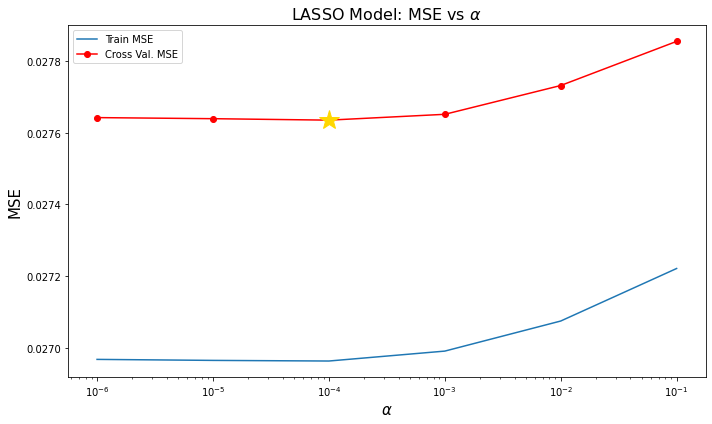

In [171]:
# plotting
plt.figure(figsize = (10,6))
plt.plot(alphas, train_scores, label = 'Train MSE')
plt.plot(alphas, cvmeans_lasso, label = 'Cross Val. MSE', c='red', marker = 'o')
plt.plot(best_alpha, min(cvmeans_lasso), marker = '*', markersize = 20, color = 'gold')
plt.xlabel(r'$\alpha$', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title(r'LASSO Model: MSE vs $\alpha$', fontsize = 16)
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()

As we can see above, the best $\alpha$ value is 0.0001. Therefore, we'll move ahead with this value when evaluating LASSO. Below, we report the results.

In [172]:
# instantiate object
best_lasso = Lasso(alpha = best_alpha, max_iter = 5000)

# fit on training data
best_lasso.fit(X_train_poly_normalized, y_train)

# get training predictions, training score
y_preds_train = best_lasso.predict(X_train_poly_normalized)
train_score_lasso = mean_squared_error(y_train, y_preds_train)

#get cross validated scores
cv_scores = cross_val_score(best_lasso, X_train_poly_normalized, y_train, cv = 10, scoring = ('neg_mean_squared_error'))
cv_score_lasso = np.absolute(np.mean(cv_scores))

print_and_update('LASSO (a = 0.0001)', cv_score_lasso, train_score_lasso, y_train, y_preds_train)

Results of the LASSO (a = 0.0001) model:
--------------------------------
Train $r^2$: 0.8736
Train MSE: 0.0258
Validation MSE: 0.0266


The LASSO model with $\alpha$ = 0.0001 gives us a validation MSE of 0.0266. Again, this is a significant improvement from the KNN model.

Below, we check to see if LASSO performed any feature selection.

In [173]:
sum(abs(best_lasso.coef_) < 0.01)

283

It did!

 ## Regression Trees and Random Forest

Next, we move on to decision trees. Below, we'll loop through different depths in order to find the best depth for a singular tree.

In [174]:
# list 1-20, inclusive
depths = np.arange(1,21,1)

# initialize lists
train_scores = []
cvmeans = []
cvstds = []

# for each depth level
for depth in depths:
    # initiate and fit model
    basemodel = DecisionTreeRegressor(max_depth = depth)
    basemodel.fit(X_train, y_train)
    
    # append train score
    train_scores.append(mean_squared_error(basemodel.predict(X_train), y_train))
    
    # perform 5-fold cross validation
    cv_scores = cross_val_score(basemodel, X_train, y_train, cv=5, scoring = ('neg_mean_squared_error'))
    cvmeans.append(np.absolute(np.mean(cv_scores)))
    cvstds.append(np.absolute(np.std(cv_scores)))

# best depth 
best_depth = cvmeans.index(min(cvmeans))
best_cv_score = cvmeans[best_depth]

# calculating lower and upper bounds
up_bound = np.array(cvmeans) + np.array(cvstds)
low_bound = np.array(cvmeans) - np.array(cvstds)

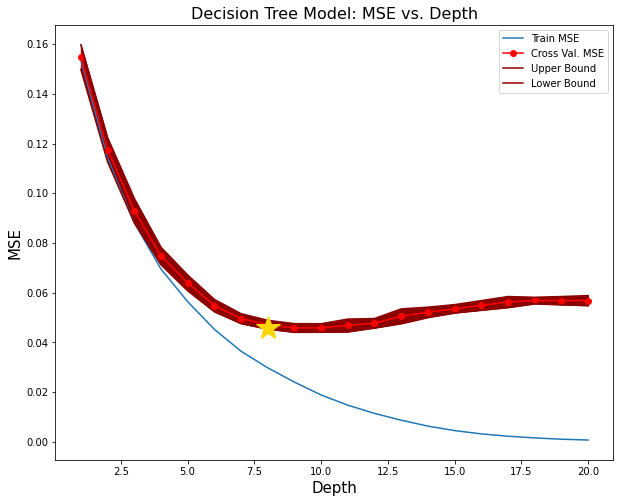

In [175]:
# plotting
plt.figure(figsize = (10, 8))
plt.plot(depths, train_scores, label = 'Train MSE')
plt.plot(depths, cvmeans, label = 'Cross Val. MSE', c='red', marker = 'o')
plt.plot(depths, up_bound, label = 'Upper Bound', color = 'darkred')
plt.plot(depths, low_bound, label = 'Lower Bound', color = 'darkred')
plt.plot(best_depth, best_cv_score, marker = '*', markersize = 25, color = 'gold')
plt.fill_between(depths, up_bound, low_bound, color='darkred')
plt.xlabel('Depth', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Decision Tree Model: MSE vs. Depth', fontsize = 16)
plt.legend()
plt.show()

As seen above, the best depth for a single tree is a depth of 8. Therefore, we'll move forward with a depth of 8 when using a single decision tree. Below, we'll report the results.

In [176]:
# instantiate object
best_singletree = DecisionTreeRegressor(max_depth = best_depth)

# fit on training data
best_singletree.fit(X_train, y_train)

# get training predictions, training score
y_preds_train = best_singletree.predict(X_train)
train_score_singletree = mean_squared_error(y_train, y_preds_train)

#get cross validated scores
cv_scores = cross_val_score(best_singletree, X_train, y_train, cv = 10, scoring = ('neg_mean_squared_error'))
cv_score_singletree = np.absolute(np.mean(cv_scores))

print_and_update(f'Single Tree (depth = {best_depth})', cv_score_singletree, train_score_singletree, y_train, y_preds_train)

Results of the Single Tree (depth = 8) model:
--------------------------------
Train $r^2$: 0.8543
Train MSE: 0.0297
Validation MSE: 0.0455


The single decision tree of depth 9 gives us a test MSE of 0.0455. This model is less accurate than the LASSO model, and about the same as the KNN model.

Moving forward, we skip the evaluation of bagging models due to its theoretical limitations and inadequacies. We know that random forests are (almost) strictly better than bagging due to the decorrelation of trees through the use of randomly generating options for each split. Therefore, we move forward by evaluating a random forest model. Here, we loop through to determine the best depth and the best number of trees for each depth.

In [177]:
# initialize lists
train_scores_rf = []
cvmeans_rf = [[],[],[],[],[],[],[],[]]
cvstds_rf = [[],[],[],[],[],[],[],[]]

# 5, 10, 15-20
depths = [5, 10, 15, 16, 17, 18 ,19 ,20]


# for each depth level
for depth in depths:
    # for each number of estimators
    for estimators in [50, 100, 200]:

        # initiate and fit model
        rf = RandomForestRegressor(n_estimators = estimators, max_depth = depth)
        rf.fit(X_train, y_train)

        # append train score
        train_scores_rf.append(mean_squared_error(rf.predict(X_train), y_train))

        # perform 5-fold cross validation
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring = ('neg_mean_squared_error'))
        cvmeans_rf[depths.index(depth)].append(np.absolute(np.mean(cv_scores)))
        cvstds_rf[depths.index(depth)].append(np.absolute(np.std(cv_scores)))

In [178]:
estimators = [50, 100, 200]

# best score, depth, and iterations
best_scores = [min(x) for x in cvmeans_rf]
best_overall = min(best_scores)
best_depth = depths[best_scores.index(min(best_scores))]
best_iter = estimators[cvmeans_rf[7].index(min(cvmeans_rf[7]))]

best_iterations = [cvmeans_rf[x].index(min(cvmeans_rf[x])) for x in range(len(depths))]
train_scores_rf = np.reshape(train_scores_rf, (3, 8)).T
best_train_scores = [min(x) for x in train_scores_rf]
up_bound_rf = []
low_bound_rf = []

# calculating lower and upper bounds
for x in range(len(best_scores)):
    up_bound_rf.append(best_scores[x] + cvstds_rf[x][best_iterations[0]])
    low_bound_rf.append(best_scores[x] - cvstds_rf[x][best_iterations[0]])

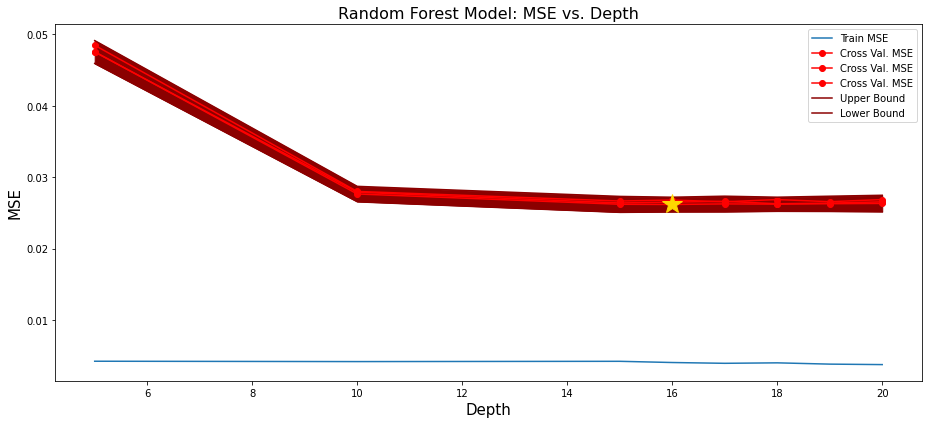

In [179]:
# plotting
plt.figure(figsize = (13,6))
plt.plot(depths, best_train_scores, label = 'Train MSE')
plt.plot(depths, cvmeans_rf, label = 'Cross Val. MSE', c='red', marker = 'o')
plt.plot(depths, up_bound_rf, label = 'Upper Bound', color = 'darkred')
plt.plot(depths, low_bound_rf, label = 'Lower Bound', color = 'darkred')
plt.plot(best_depth, best_overall, marker = '*', markersize = 20, color = 'gold')
plt.fill_between(depths, up_bound_rf, low_bound_rf, color='darkred')
plt.xlabel('Depth', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Random Forest Model: MSE vs. Depth', fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()

As seen above, the best depth for a random forest model is 16 and this was with 200 iterations. Therefore, we'll move forward with a depth of 16 and 200 iterations. Below, we report the results.

In [180]:
# instantiate object
best_rf = RandomForestRegressor(n_estimators = best_iter, max_depth = best_depth)

# fit on training data
best_rf.fit(X_train, y_train)

# get training predictions, training score
y_preds_train = best_rf.predict(X_train)
train_score_rf = mean_squared_error(y_train, y_preds_train)

#get cross validated scores
cv_scores = cross_val_score(best_rf, X_train, y_train, cv = 5, scoring = ('neg_mean_squared_error'))
cv_score_rf = np.absolute(np.mean(cv_scores))

print_and_update(f'Random Forest (depth = {best_depth})', cv_score_rf, train_score_rf, y_train, y_preds_train)

Results of the Random Forest (depth = 16) model:
--------------------------------
Train $r^2$: 0.9751
Train MSE: 0.0051
Validation MSE: 0.0263


The single decision tree of depth 16 with 200 iterations gives us a validation MSE of 0.0263. This model is the most accurate we've seen thus far!


## Boosting

Now we'll move into boosting. Below we'll tune based on tree depth.

In [181]:
# initialize lists
adaboost_mse = []

depths = [3,4,5,6,7]

# initialize lists
train_scores = []
adameans = []
adastds = []

# for max depths 3-7 (inclusive), fit adaboost model and then append train and test scores
for depth in depths:
    depth_tree = DecisionTreeRegressor(max_depth = depth)
    adaboost = AdaBoostRegressor(depth_tree, n_estimators = 200, learning_rate = 0.05)
    adaboost.fit(X_train, y_train)
    
    # append train score
    train_scores.append(mean_squared_error(adaboost.predict(X_train), y_train))
    
    # perform 5-fold cross 6alidation
    ada_scores = cross_val_score(adaboost, X_train, y_train, cv=5, scoring = ('neg_mean_squared_error'))
    adameans.append(np.absolute(np.mean(ada_scores)))
    adastds.append(np.absolute(np.std(ada_scores)))

# find the best depth from above
best_depth = depths[adameans.index(min(adameans))]
best_score = min(adameans)

# calculating lower and upper bounds
up_bound_ada = np.array(adameans) + np.array(adastds)
low_bound_ada = np.array(adameans) - np.array(adastds)

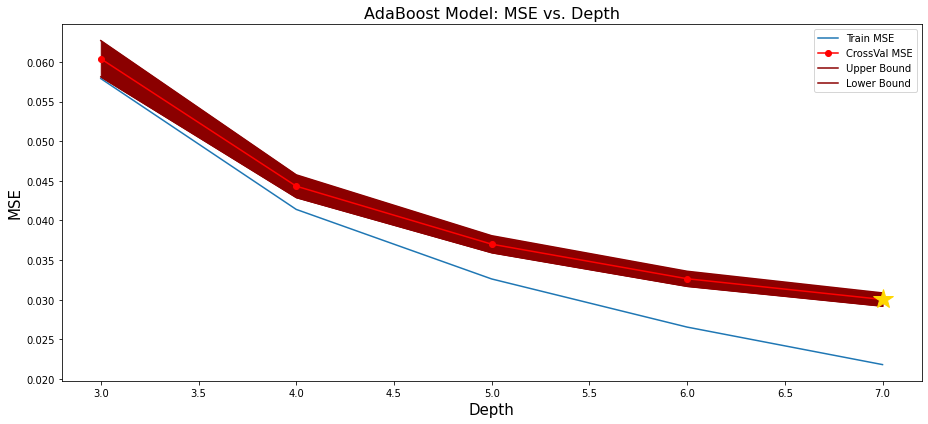

In [182]:
# plot 1
plt.figure(figsize = (13,6))
plt.plot(depths, train_scores, label = 'Train MSE')
plt.plot(depths, adameans, label = 'CrossVal MSE', c='red', marker = 'o')
plt.plot(depths, up_bound_ada, label = 'Upper Bound', color = 'darkred')
plt.plot(depths, low_bound_ada, label = 'Lower Bound', color = 'darkred')
plt.plot(best_depth, best_score, marker = '*', markersize = 20, color = 'gold')
plt.fill_between(depths, up_bound_ada, low_bound_ada, color='darkred')
plt.xlabel('Depth', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('AdaBoost Model: MSE vs. Depth', fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()

As we can see above, the best depth for an AdaBoost tree is 7. It seems that if we continued to increase depth, the model's MSE would also decrease. However, we don't want to overfit the training and validation set as we know that boosting methods are supposed to made up of weaker learners. The combination of weak learners by boosting is what eventually makes the model expressive. Therefore, we will move forward with a value of 7. We should also perform cross-validation on the number of estimators included. We will do so below.

In [183]:
estimators = [100,200,300]

train_scores = []
adameans = []
adastds = []

# for each number of estimators
for estimator in estimators:
    depth_tree = DecisionTreeRegressor(max_depth = best_depth)
    adaboost = AdaBoostRegressor(depth_tree, n_estimators = estimator, learning_rate = 0.05)
    adaboost.fit(X_train, y_train)
    
    # append train score
    train_scores.append(mean_squared_error(adaboost.predict(X_train), y_train))
    
    # perform 5-fold cross validation
    ada_scores = cross_val_score(adaboost, X_train, y_train, cv=5, scoring = ('neg_mean_squared_error'))
    adameans.append(np.absolute(np.mean(ada_scores)))
    adastds.append(np.absolute(np.std(ada_scores)))    

# best number of estimators
best_num = estimators[adameans.index(min(adameans))]
best_score = min(adameans)

# calculating lower and upper bounds
up_bound_ada = np.array(adameans) + np.array(adastds)
low_bound_ada = np.array(adameans) - np.array(adastds)

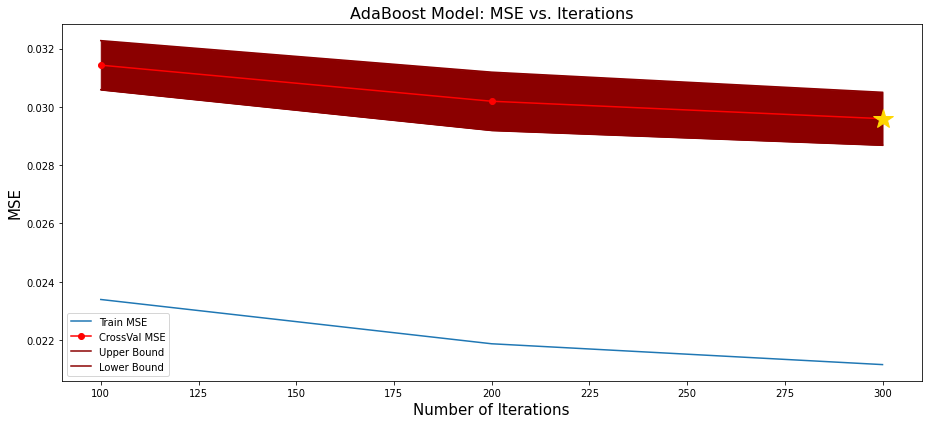

In [184]:
# plotting
plt.figure(figsize = (13,6))
plt.plot(estimators, train_scores, label = 'Train MSE')
plt.plot(estimators, adameans, label = 'CrossVal MSE', c='red', marker = 'o')
plt.plot(estimators, up_bound_ada, label = 'Upper Bound', color = 'darkred')
plt.plot(estimators, low_bound_ada, label = 'Lower Bound', color = 'darkred')
plt.plot(best_num, best_score, marker = '*', markersize = 20, color = 'gold')
plt.fill_between(estimators, up_bound_ada, low_bound_ada, color='darkred')
plt.xlabel('Number of Iterations', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('AdaBoost Model: MSE vs. Iterations', fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()

The plot above shows the best number of estimators is 300. This, along with the selection of a depth of 7, will combine to make our AdaBoost model moving forward. Below, we report the results.

In [185]:
# instantiate object
best_tree = RandomForestRegressor(max_depth = best_depth)
best_ada = AdaBoostRegressor(best_tree, n_estimators = 100, learning_rate = 0.05)

# fit on training data
best_ada.fit(X_train, y_train)

# get training predictions, training score
y_preds_train = best_ada.predict(X_train)
train_score_ada = mean_squared_error(y_train, y_preds_train)

#get cross validated scores
cv_scores = cross_val_score(best_ada, X_train, y_train, cv = 5, scoring = ('neg_mean_squared_error'))
cv_score_ada = np.absolute(np.mean(cv_scores))

print_and_update(f'AdaBoost (depth = {best_depth})', cv_score_ada, train_score_ada, y_train, y_preds_train)

Results of the AdaBoost (depth = 7) model:
--------------------------------
Train $r^2$: 0.8903
Train MSE: 0.0224
Validation MSE: 0.0292


The AdaBoost model of depth 7 and 300 iterations gives us a validation MSE of 0.0292. This gives us slightly worse performance than the LASSO and random forest models. Let's take a look at the results thus far.

In [186]:
# create pandas df, inspect
best_mse_df = pd.DataFrame.from_dict(best_mse_dict)
best_mse_df

,Train,Val
Preliminary,0.0883,0.0885
KNN (k = 5),0.0290,0.0452
LASSO (a = 0.0001),0.0258,0.0266
Single Tree (depth = 8),0.0297,0.0455
Random Forest (depth = 16),0.0051,0.0263
AdaBoost (depth = 7),0.0224,0.0292


Lastly, we attempt to train a simple TensorFlow neural network. Due to the complexity of these models, we did not perform tuning of any hyper-parameters. We just want to evaluate the potential of a well-tuned neural network based on the performance of this simple one.

In [187]:
# define a TF NN class
class TensorFlowNN():
    def __init__(self, norm):
        """
        Initialize your `neural_net_model`.
        """
        self.norm = norm

        model = keras.Sequential([
        self.norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='relu'),
        ])

        model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
        
        self.model = model

    def train(self, X_train: np.ndarray, y_train: np.ndarray):

        history = self.model.fit(X_train, y_train, epochs=100, validation_split = .1)
        self.plot_loss = self.plot_loss(history)

    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = self.model.predict(X)
        return preds

    def plot_loss(self, history):
        print('\n\n\n\n\n')
        plt.figure(figsize = (12,8))
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title('Neural Net Model: MSE vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.ylim([0,0.5])
        plt.grid(True)



normalizer = tf.keras.layers.Normalization(axis=-1)

Epoch 1/100
240/240 [==============================] - 1s 2ms/step - loss: 497.6629 - val_loss: 4.0604
Epoch 2/100
240/240 [==============================] - 0s 2ms/step - loss: 3.6034 - val_loss: 3.1776
Epoch 3/100
240/240 [==============================] - 0s 1ms/step - loss: 2.7519 - val_loss: 2.4278
Epoch 4/100
240/240 [==============================] - 0s 2ms/step - loss: 2.0139 - val_loss: 1.7989
Epoch 5/100
240/240 [==============================] - 0s 2ms/step - loss: 1.4976 - val_loss: 1.3399
Epoch 6/100
240/240 [==============================] - 0s 2ms/step - loss: 1.1170 - val_loss: 1.0114
Epoch 7/100
240/240 [==============================] - 0s 1ms/step - loss: 0.8637 - val_loss: 0.7567
Epoch 8/100
240/240 [==============================] - 0s 1ms/step - loss: 0.6802 - val_loss: 0.6005
Epoch 9/100
240/240 [==============================] - 0s 2ms/step - loss: 0.5443 - val_loss: 0.4897
Epoch 10/100
240/240 [==============================] - 0s 1ms/step - loss: 0.4459 - val_

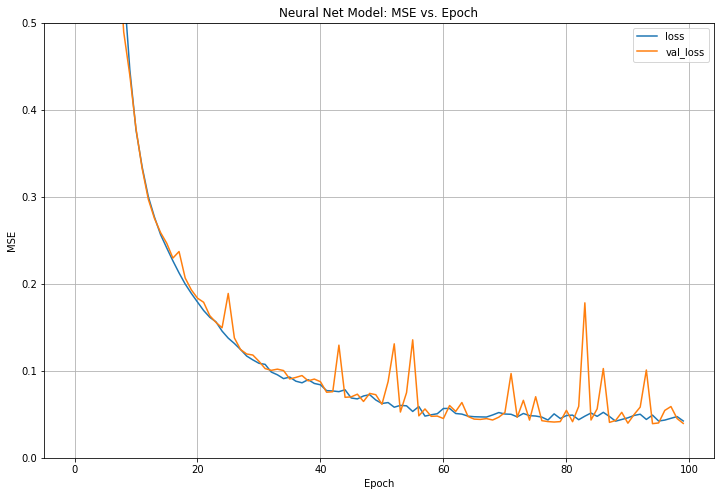

In [188]:
# initialize, fit, and predict
tf_nn = TensorFlowNN(normalizer)
tf_nn.train(X_train.values, y_train)
y_preds_train = tf_nn.predict(X_train)

This simple TF neural network gives us a validation MSE of 0.0338. This doesn't give us the best performance, however, we can definitely see the potential if we were able to perform tuning. If we knew more about TensorFlow, we would move forward in tuning this neural network.\
\
But let's check out the final results!

In [189]:
best_mse_dict['Train']['TensorFlow NN'] = 0.0319
best_mse_dict['Val']['TensorFlow NN'] = 0.0338

# create pandas df, inspect
best_mse_df = pd.DataFrame.from_dict(best_mse_dict)
best_mse_df

,Train,Val
Preliminary,0.0883,0.0885
KNN (k = 5),0.0290,0.0452
LASSO (a = 0.0001),0.0258,0.0266
Single Tree (depth = 8),0.0297,0.0455
Random Forest (depth = 16),0.0051,0.0263
AdaBoost (depth = 7),0.0224,0.0292
TensorFlow NN,0.0319,0.0338


As we can see, the Random Forest model of depth 16 has the lowest validation MSE. While its by a small margin, we must remember that the response variable has been transformed with log base 10.\
\
Even though the Random Forest model has the lowest validation MSE, we choose to move forward with the LASSO model as it seems much less overfit to the training data. With a train MSE of 0.0051, the Random Forest model seems like it won't generalize as well.\
\
Let's move forward by re-fitting the LASSO to the whole training set, and then predicting on the test set!

In [190]:
# train to the entire training set
best_lasso.fit(X_train_poly_normalized, y_train)

# predict on the test set
y_preds_test = best_lasso.predict(X_test_poly_normalized)

In [191]:
# report results
print(f'Results of the LASSO model (Test):')
print('--------------------------------')
print('Test r^2:', round(r2_score(y_test, y_preds_test),4))
print('Test MSE:', round(mean_squared_error(y_test, y_preds_test),4))

Results of the LASSO model (Test):
--------------------------------
Test r^2: 0.8578
Test MSE: 0.0287


# Evaluating Players and Clubs

In [192]:
# refit the model to the entire data set
X_poly_normalized = PolynomialFeatures(degree=3).fit_transform(X)
y = np.log10(y)
best_lasso.fit(X_poly_normalized, y)
y_pred = best_lasso.predict(X_poly_normalized)

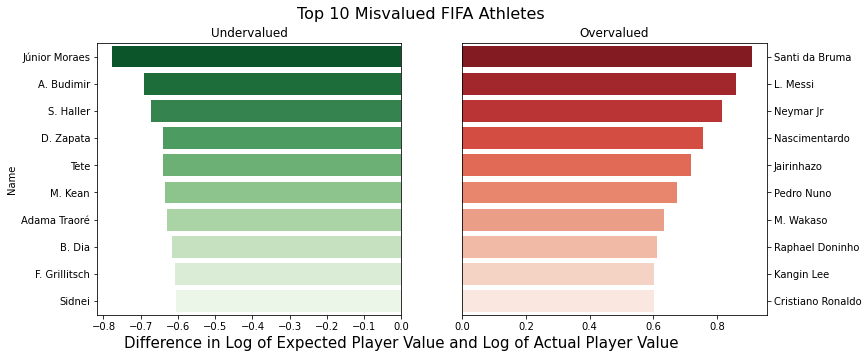

In [193]:
# retrieve model predictions for Each Player and Calculate Differences
df21_sub['Model_Preds'] = y_pred
df21_sub["diff"] = df21_sub["Model_Preds"] - np.log10(df21_sub["Value (Eur)"])

underpayd = df21_sub.nsmallest(10, "diff")
overpayd = df21_sub.nlargest(10,  "diff")

# visualize
fig, axs = plt.subplots(1,2, figsize = (12,5))
sns.barplot(x = overpayd["diff"], y = overpayd['Name'], ax = axs[1], palette = "Reds_r")
sns.barplot(x = underpayd["diff"], y = underpayd['Name'], ax = axs[0], palette = "Greens_r")
axs[1].yaxis.tick_right()
axs[1].set_ylabel("")
fig.suptitle('Top 10 Misvalued FIFA Athletes', fontsize=16)
axs[0].set_title("Undervalued")
axs[1].set_title("Overvalued")
axs[0].set_xlabel("Difference in Log of Expected Player Value and Log of Actual Player Value", fontsize = 15, x=1,y=1)
axs[1].set_xlabel("")
plt.show()


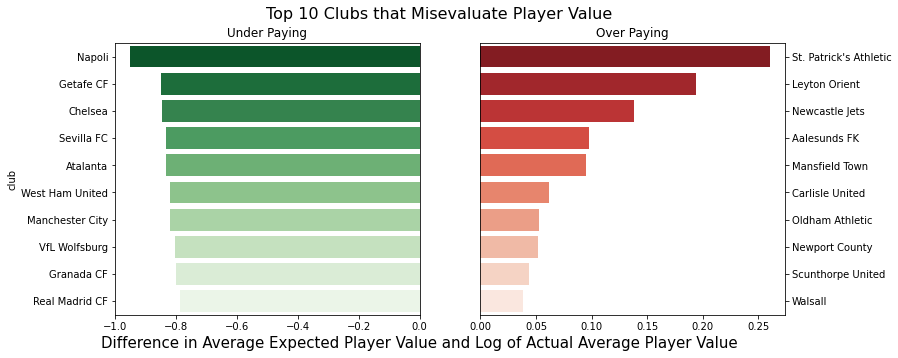

In [194]:
# aggregate by Club 
df21_sub["log_value"] = np.log10(df21_sub["Value (Eur)"])
club_avg = df21_sub.groupby("Club").agg("mean")
club_avg

# using the model predict for the average player in each club
X_avg, y_avg = club_avg[regression_vars], club_avg['log_value'].values
X_avg_ploy = PolynomialFeatures(degree=3).fit_transform(X_avg)
avg_test_pred = best_lasso.predict(X_avg_ploy)

# calculate Differences
club_avg['avg_model_pred'] = avg_test_pred
club_avg = club_avg[['log_value', 'avg_model_pred']]
club_avg['diff'] = club_avg['avg_model_pred'] - club_avg['log_value']

underpayed = club_avg.nsmallest(10, "diff")
overpayed = club_avg.nlargest(10,  "diff")

underpayed['club'] = underpayed.index
overpayed['club'] = overpayed.index

# visualize!
fig, axs = plt.subplots(1,2, figsize = (12,5))
sns.barplot(x = overpayed["diff"], y = overpayed['club'], ax = axs[1], palette = "Reds_r")
sns.barplot(x = underpayed["diff"], y = underpayed['club'], ax = axs[0], palette = "Greens_r")
axs[1].yaxis.tick_right()
axs[1].set_ylabel("")
fig.suptitle('Top 10 Clubs that Misevaluate Player Value', fontsize=16)
axs[0].set_title("Under Paying")
axs[1].set_title("Over Paying")
axs[0].set_xlabel("Difference in Average Expected Player Value and Log of Actual Average Player Value", fontsize = 15, x=1,y=1)
axs[1].set_xlabel("")
plt.show()
